# Emotion Recognition using a CNN model with integrated heatmap/prioritised convolution operation

Importing the libraries I will be using

landmark detection and extraction then use CNN to determine emotion.

# Prepare data

Download the AffectNET dataset from kaggle, unfortunately kaggle dont let you download the dataset to a specific location so i just moved it to my emotion_recognition folder 

In [ ]:
import kagglehub

# Download the dataset
try:
    path = kagglehub.dataset_download("fatihkgg/affectnet-yolo-format")
    print("Path to dataset files:", path)
except Exception as e:
    print("Error downloading dataset:", e)

In [1]:
import tensorflow as tf
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16

print("TensorFlow version:", tf.__version__)
model = VGG16(weights='imagenet')
print("VGG16 model loaded successfully!")
print("NumPy version:", np.__version__)
print("scikit-learn version:", train_test_split.__module__)
print("OpenCV version:", cv2.__version__)
print("GPUs available:", tf.config.list_physical_devices('GPU'))



TensorFlow version: 2.10.0
VGG16 model loaded successfully!
NumPy version: 1.23.5
scikit-learn version: sklearn.model_selection._split
OpenCV version: 4.7.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Load the dataset
def load_images_from_directory(directory, target_size=(128, 128)):
    images = []
    labels = []
    classes = os.listdir(directory)
    class_map = {cls: idx for idx, cls in enumerate(classes)}
    
    for cls in classes:
        cls_dir = os.path.join(directory, cls)
        for img_name in os.listdir(cls_dir):
            img_path = os.path.join(cls_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, target_size)
                images.append(img)
                labels.append(class_map[cls])
    
    return np.array(images), np.array(labels), class_map

dataset_dir = "./AffectNET/train_organized"
images, labels, class_map = load_images_from_directory(dataset_dir)

# Normalize images
images = images / 255.0

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
print(f"Dataset loaded. Classes: {class_map}")


Dataset loaded. Classes: {'Anger': 0, 'Contempt': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Sad': 6, 'Surprise': 7}


In [ ]:
image_path = './AffectNET/train_organized/Happy/ffhq_0.png'  # Ensure the image exists at this path

1/1 [==============================] - 3s 3s/step


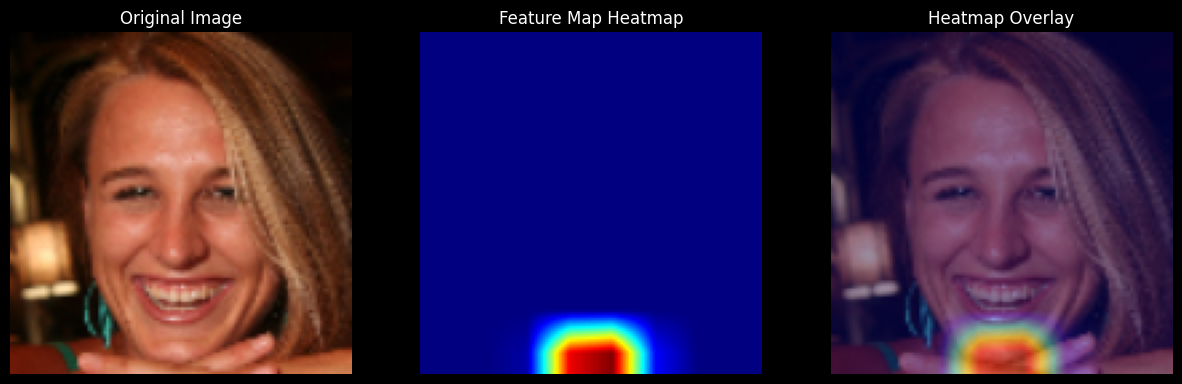

In [3]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

# Load VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
model = Model(inputs=base_model.input, outputs=base_model.get_layer("block5_conv3").output)

# Load and preprocess the image
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))
    image_clean_copy = image.copy()
    image = image.astype('float32')
    preprocessed_image = preprocess_input(np.expand_dims(image, axis=0))
    return image_clean_copy, preprocessed_image

# Replace 'path_to_image.jpg' with the actual image path
image_path = './AffectNET/train_organized/Happy/ffhq_0.png'  # Ensure the image exists
original_image, preprocessed_image = load_and_preprocess_image(image_path)

# Extract features
features = model.predict(preprocessed_image)

# Select a feature map (e.g., first channel)
feature_map = features[0, :, :, 0]

# Normalize the feature map to the range [0, 1]
feature_map_normalized = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())

# Resize the feature map to the original image size
feature_map_rescaled = cv2.resize(feature_map_normalized, (128, 128))

# Create a heatmap (red for high intensity, blue for low)
heatmap = cv2.applyColorMap((feature_map_rescaled * 255).astype(np.uint8), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# Overlay the heatmap on the original image
overlay_image = cv2.addWeighted(original_image.astype(np.uint8), 0.6, heatmap, 0.4, 0)

# Plot the results
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(original_image.astype(np.uint8))
plt.title("Original Image")
plt.axis("off")

# Feature map heatmap
plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title("Feature Map Heatmap")
plt.axis("off")

# Overlay of heatmap on original image
plt.subplot(1, 3, 3)
plt.imshow(overlay_image)
plt.title("Heatmap Overlay")
plt.axis("off")

plt.show()


# Train model

In [ ]:
# Flatten the features
train_features_flat = train_features.reshape(train_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

# Verify shapes
print(f"Flattened train feature shape: {train_features_flat.shape}")
print(f"Flattened test feature shape: {test_features_flat.shape}")


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define a model using extracted features
def build_classifier(input_dim, num_classes):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

input_dim = train_features_flat.shape[1]
num_classes = len(class_map)
classifier = build_classifier(input_dim, num_classes)

# Train the model
history = classifier.fit(
    train_features_flat,
    y_train,
    validation_data=(test_features_flat, y_test),
    epochs=10,
    batch_size=32
)


In [ ]:
# Evaluate the model
loss, accuracy = classifier.evaluate(test_features_flat, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Save the model
classifier.save("feature_extraction_classifier.h5")


# Test model

Loading images from: ./AffectNET/train_organized\Anger
Loading images from: ./AffectNET/train_organized\Contempt
Loading images from: ./AffectNET/train_organized\Disgust
Loading images from: ./AffectNET/train_organized\Fear
Loading images from: ./AffectNET/train_organized\Happy
Loading images from: ./AffectNET/train_organized\Neutral
Loading images from: ./AffectNET/train_organized\Sad
Loading images from: ./AffectNET/train_organized\Surprise
Loaded 4934 images from ./AffectNET/train_organized.
Loading images from: ./AffectNET/valid_organized\Anger
Loading images from: ./AffectNET/valid_organized\Contempt
Loading images from: ./AffectNET/valid_organized\Disgust
Loading images from: ./AffectNET/valid_organized\Fear
Loading images from: ./AffectNET/valid_organized\Happy
Loading images from: ./AffectNET/valid_organized\Neutral
Loading images from: ./AffectNET/valid_organized\Sad
Loading images from: ./AffectNET/valid_organized\Surprise
Loaded 1860 images from ./AffectNET/valid_organized.


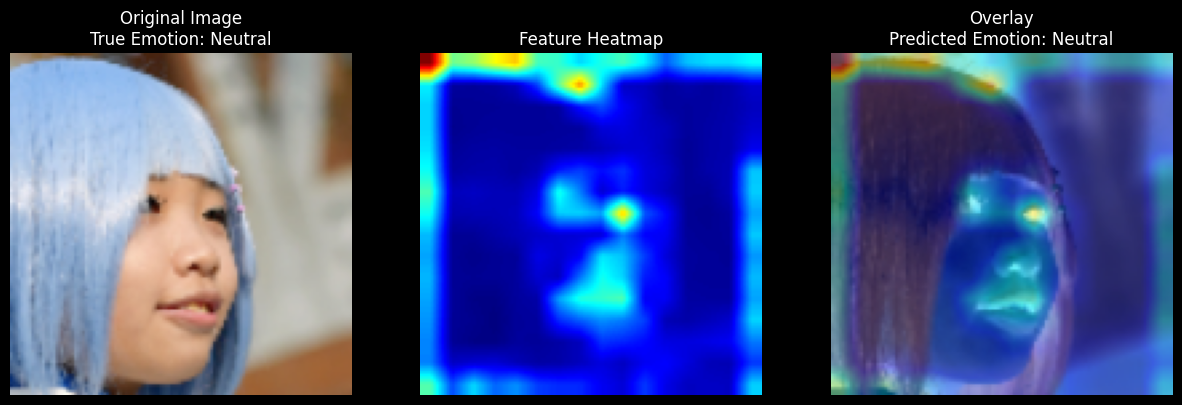

32/32 [==============================] - 0s 6ms/step - loss: 1.9403 - accuracy: 0.5563
Test Accuracy: 55.63%
Error: Camera not found or cannot be opened.


In [10]:
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization
)
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import random

# ========================================
# 1. Load AffectNet Dataset
# ========================================

# Dataset paths
TRAIN_PATH = "./AffectNET/train_organized"
VALID_PATH = "./AffectNET/valid_organized"
TEST_PATH = "./AffectNET/test_organized"
EMOTIONS = ["Anger", "Contempt", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

# Function to load dataset
def load_affectnet_dataset(dataset_path, emotions, image_size=(128, 128)):
    images = []
    labels = []

    for label, emotion in enumerate(emotions):
        folder_path = os.path.join(dataset_path, emotion)
        if not os.path.exists(folder_path):
            print(f"Warning: Folder {folder_path} does not exist. Skipping.")
            continue

        print(f"Loading images from: {folder_path}")
        for file_name in os.listdir(folder_path):
            if file_name.endswith(".png"):
                file_path = os.path.join(folder_path, file_name)
                try:
                    # Read and resize the image
                    image = cv2.imread(file_path)
                    if image is None:
                        print(f"Warning: Unable to load image {file_path}. Skipping.")
                        continue
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, image_size)
                    images.append(image)
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading image {file_path}: {e}")

    images = np.array(images, dtype="float32") / 255.0  # Normalize to [0, 1]
    labels = np.array(labels)

    print(f"Loaded {len(images)} images from {dataset_path}.")
    return images, labels

# Load the AffectNet datasets
X_train, y_train = load_affectnet_dataset(TRAIN_PATH, EMOTIONS)
X_val, y_val = load_affectnet_dataset(VALID_PATH, EMOTIONS)
X_test, y_test = load_affectnet_dataset(TEST_PATH, EMOTIONS)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=len(EMOTIONS))
y_val = to_categorical(y_val, num_classes=len(EMOTIONS))
y_test = to_categorical(y_test, num_classes=len(EMOTIONS))

# ========================================
# 2. Feature Extractor Model
# ========================================

def create_feature_extractor(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)  # Flatten for feature extraction
    return Model(inputs, x, name="FeatureExtractor")

feature_extractor = create_feature_extractor()
feature_extractor.summary()

# ========================================
# 3. Emotion Classifier Model
# ========================================

def create_emotion_classifier(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(256, activation="relu")(inputs)
    x = BatchNormalization()(x)
    x = Dense(128, activation="relu")(x)
    x = BatchNormalization()(x)
    outputs = Dense(len(EMOTIONS), activation="softmax")(x)  # Classes = len(EMOTIONS)
    return Model(inputs, outputs, name="EmotionClassifier")

feature_dim = feature_extractor.output_shape[-1]
emotion_classifier = create_emotion_classifier((feature_dim,))
emotion_classifier.summary()

# ========================================
# 4. Combined Model
# ========================================

def create_combined_model(feature_extractor, emotion_classifier):
    inputs = Input(shape=(128, 128, 3))
    features = feature_extractor(inputs)
    outputs = emotion_classifier(features)
    return Model(inputs, outputs, name="EmotionRecognitionModel")

combined_model = create_combined_model(feature_extractor, emotion_classifier)
combined_model.summary()

# ========================================
# 5. Compile and Train
# ========================================

combined_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model
history = combined_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

# ========================================
# 6. Visualize Features and Results
# ========================================

def visualize_features(image, feature_extractor):
    # Extract features
    features = feature_extractor.predict(np.expand_dims(image, axis=0))

    # Reshape feature map for visualization
    feature_map = features.reshape((16, 16, -1))  # Adjust based on final pooling size

    # Normalize the first channel for heatmap visualization
    feature_map_aggregated = np.mean(feature_map, axis=-1)
    feature_map_normalized = (feature_map_aggregated - feature_map_aggregated.min()) / (feature_map_aggregated.max() - feature_map_aggregated.min())

    # Resize feature map to match input image size
    feature_map_rescaled = cv2.resize(feature_map_normalized, (128, 128))

    # Create heatmap
    heatmap = cv2.applyColorMap((feature_map_rescaled * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Overlay heatmap on the original image
    overlay_image = cv2.addWeighted((image * 255).astype(np.uint8), 0.6, heatmap, 0.4, 0)

    return overlay_image, heatmap

# Random test image from the test dataset folder
def get_random_test_image(test_path, emotions, image_size=(128, 128)):
    emotion = random.choice(emotions)
    emotion_folder = os.path.join(test_path, emotion)
    random_image = random.choice(os.listdir(emotion_folder))
    image_path = os.path.join(emotion_folder, random_image)

    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, image_size)

    return image, emotion

# Test on a random image and display prediction
random_image, true_emotion = get_random_test_image(TEST_PATH, EMOTIONS)
prediction = combined_model.predict(np.expand_dims(random_image, axis=0))
predicted_emotion = EMOTIONS[np.argmax(prediction)]

# Visualize results
overlay_image, heatmap = visualize_features(random_image, feature_extractor)

plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.imshow(random_image)
plt.title(f"Original Image\nTrue Emotion: {true_emotion}")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title("Feature Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay_image)
plt.title(f"Overlay\nPredicted Emotion: {predicted_emotion}")
plt.axis("off")

plt.show()

# ========================================
# 7. Evaluate the Model
# ========================================

test_loss, test_accuracy = combined_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# ========================================
# 8. Live Camera Feed
# ========================================
def live_camera_feed(model, feature_extractor, emotions, image_size=(128, 128)):
    cap = cv2.VideoCapture(0)  # Open the default camera

    if not cap.isOpened():
        print("Error: Camera not found or cannot be opened.")
        return

    print("Press 'q' to quit.")
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error: Unable to read frame from camera.")
            break

        # Preprocess the frame
        frame_resized = cv2.resize(frame, image_size)
        frame_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
        frame_normalized = frame_rgb / 255.0

        # Predict emotion
        prediction = model.predict(np.expand_dims(frame_normalized, axis=0))
        predicted_emotion = emotions[np.argmax(prediction)]

        # Visualize features
        overlay_image, _ = visualize_features(frame_normalized, feature_extractor)

        # Display the frame
        cv2.putText(
            overlay_image,
            f"Emotion: {predicted_emotion}",
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (255, 255, 255),
            2,
            cv2.LINE_AA,
        )

        cv2.imshow("Emotion Recognition", cv2.cvtColor(overlay_image, cv2.COLOR_RGB2BGR))

        # Exit on pressing 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Uncomment to test live camera feed
live_camera_feed(combined_model, feature_extractor, EMOTIONS)


In [11]:
import cv2

cap = cv2.VideoCapture(1)  # Replace 1 with the detected index
if not cap.isOpened():
    print("Camera not detected!")
else:
    print("Camera detected. Press 'q' to quit.")
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame.")
            break
        cv2.imshow("Webcam Test", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()


Scanning for available cameras...
No camera at index 0
No camera at index 1
No camera at index 2
No camera at index 3
No camera at index 4
No camera at index 5
No camera at index 6
No camera at index 7
No camera at index 8
No camera at index 9
